# Baseline Results for Uni-modal Approaches

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D,  MaxPooling1D, ConvLSTM1D
from tensorflow.keras import models

warnings.filterwarnings("ignore")

In [2]:
def load_file(file, prediction_type):
    df = pd.read_csv(file, header=0)
    labels = df[prediction_type]
    df = df.drop(columns=['pain_area', 'pain_level'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df.to_numpy(), labels

def load_dataset(input_filepath, prediction_type, modality):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # y_train = pd.get_dummies(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    # y_test = pd.get_dummies(y)
    # y_test, tmp = y_test.align(y_train, join='outer', axis=1, fill_value=0)
    return X_train, X_test, y_train, y_test

In [3]:
accuracies = []
aucs = []
model_names = ['M1.1 CNN+LSTM', 'M1.2 ConvLSTM', 'M1.3 CNN+LSTM', 'M1.4 ConvLSTM', 'M2.1 CNN+LSTM', 'M2.2 ConvLSTM', 'M2.3 CNN+LSTM', 'M2.4 ConvLSTM']

## 1. Body Modality (Skeleton)

### 1.1 Pain area prediction - CNN+LSTM

#### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_area', 'skeleton')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 38) (534, 5)
(81, 1, 350, 38) (81, 5)


#### Model

In [5]:
epochs, batch_size = 25, 256
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [6]:
def get_CNN_model(n_features, n_length, n_outputs):
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,
        activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

In [7]:
model = get_CNN_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 348, 64)    7360      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 348, 32)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 11136)      0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               4494800   
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                        

#### KFold CV

Epoch 1/25
2/2 - 2s - loss: 1.4765 - accuracy: 0.5140 - auc_1: 0.7268 - val_loss: 1.3906 - val_accuracy: 0.5337 - val_auc_1: 0.7984 - 2s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 1.3696 - accuracy: 0.5702 - auc_1: 0.8033 - val_loss: 1.3530 - val_accuracy: 0.5337 - val_auc_1: 0.7575 - 242ms/epoch - 121ms/step
Epoch 3/25
2/2 - 0s - loss: 1.3071 - accuracy: 0.5702 - auc_1: 0.7834 - val_loss: 1.3055 - val_accuracy: 0.5337 - val_auc_1: 0.7992 - 370ms/epoch - 185ms/step
Epoch 4/25
2/2 - 0s - loss: 1.2596 - accuracy: 0.5702 - auc_1: 0.8093 - val_loss: 1.2726 - val_accuracy: 0.5337 - val_auc_1: 0.7992 - 316ms/epoch - 158ms/step
Epoch 5/25
2/2 - 0s - loss: 1.2295 - accuracy: 0.5702 - auc_1: 0.8056 - val_loss: 1.2516 - val_accuracy: 0.5337 - val_auc_1: 0.7992 - 313ms/epoch - 156ms/step
Epoch 6/25
2/2 - 0s - loss: 1.2108 - accuracy: 0.5702 - auc_1: 0.8042 - val_loss: 1.2388 - val_accuracy: 0.5337 - val_auc_1: 0.7992 - 294ms/epoch - 147ms/step
Epoch 7/25
2/2 - 0s - loss: 1.2004 - accuracy: 0.570

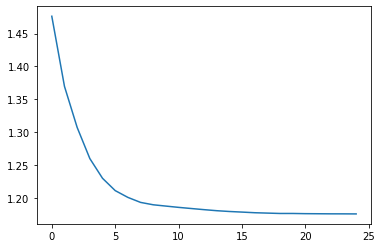

Epoch 1/25
2/2 - 3s - loss: 1.4319 - accuracy: 0.5449 - auc_2: 0.7117 - val_loss: 1.3605 - val_accuracy: 0.5787 - val_auc_2: 0.7557 - 3s/epoch - 2s/step
Epoch 2/25
2/2 - 0s - loss: 1.3623 - accuracy: 0.5478 - auc_2: 0.7407 - val_loss: 1.2949 - val_accuracy: 0.5787 - val_auc_2: 0.7467 - 327ms/epoch - 163ms/step
Epoch 3/25
2/2 - 0s - loss: 1.3132 - accuracy: 0.5478 - auc_2: 0.7374 - val_loss: 1.2744 - val_accuracy: 0.5787 - val_auc_2: 0.7472 - 270ms/epoch - 135ms/step
Epoch 4/25
2/2 - 0s - loss: 1.2874 - accuracy: 0.5478 - auc_2: 0.7358 - val_loss: 1.2722 - val_accuracy: 0.5787 - val_auc_2: 0.7472 - 344ms/epoch - 172ms/step
Epoch 5/25
2/2 - 0s - loss: 1.2832 - accuracy: 0.5478 - auc_2: 0.7377 - val_loss: 1.2433 - val_accuracy: 0.5787 - val_auc_2: 0.7472 - 384ms/epoch - 192ms/step
Epoch 6/25
2/2 - 0s - loss: 1.2570 - accuracy: 0.5478 - auc_2: 0.7445 - val_loss: 1.2219 - val_accuracy: 0.5787 - val_auc_2: 0.7935 - 404ms/epoch - 202ms/step
Epoch 7/25
2/2 - 0s - loss: 1.2367 - accuracy: 0.547

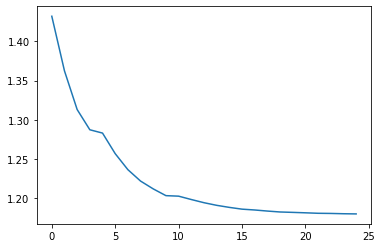

Epoch 1/25
2/2 - 2s - loss: 1.6846 - accuracy: 0.2191 - auc_3: 0.5467 - val_loss: 1.3384 - val_accuracy: 0.5618 - val_auc_3: 0.7205 - 2s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 1.3237 - accuracy: 0.5562 - auc_3: 0.7494 - val_loss: 1.2891 - val_accuracy: 0.5618 - val_auc_3: 0.7955 - 231ms/epoch - 116ms/step
Epoch 3/25
2/2 - 0s - loss: 1.2798 - accuracy: 0.5562 - auc_3: 0.8091 - val_loss: 1.2592 - val_accuracy: 0.5618 - val_auc_3: 0.7960 - 220ms/epoch - 110ms/step
Epoch 4/25
2/2 - 0s - loss: 1.2562 - accuracy: 0.5562 - auc_3: 0.8080 - val_loss: 1.2410 - val_accuracy: 0.5618 - val_auc_3: 0.8062 - 225ms/epoch - 113ms/step
Epoch 5/25
2/2 - 0s - loss: 1.2393 - accuracy: 0.5562 - auc_3: 0.8044 - val_loss: 1.2228 - val_accuracy: 0.5618 - val_auc_3: 0.8093 - 233ms/epoch - 117ms/step
Epoch 6/25
2/2 - 0s - loss: 1.2223 - accuracy: 0.5562 - auc_3: 0.8006 - val_loss: 1.2115 - val_accuracy: 0.5618 - val_auc_3: 0.8062 - 234ms/epoch - 117ms/step
Epoch 7/25
2/2 - 0s - loss: 1.2097 - accuracy: 0.556

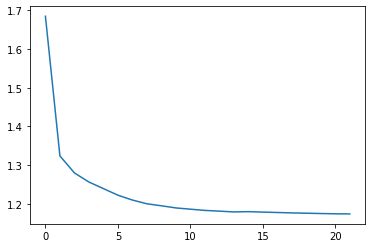

In [8]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = get_CNN_model(n_features, n_length, n_outputs)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [9]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 50.617%

AUC: 0.8148


### 1.2 Pain area detection - Convolutional LSTM

#### Model

In [10]:
def get_convLSTM_model(n_features, n_length, n_outputs):
    model = models.Sequential()
    model.add(ConvLSTM1D(filters=64, kernel_size=(3), activation='relu', input_shape=(None, n_length, n_features)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

In [11]:
model = get_convLSTM_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 348, 64)           78592     
                                                                 
 flatten_4 (Flatten)         (None, 22272)             0         
                                                                 
 dense_8 (Dense)             (None, 100)               2227300   
                                                                 
 dense_9 (Dense)             (None, 5)                 505       
                                                                 
Total params: 2,306,397
Trainable params: 2,306,397
Non-trainable params: 0
_________________________________________________________________


#### KFold CV

Epoch 1/25
1/1 - 3s - loss: 43.7690 - accuracy: 0.0591 - auc_5: 0.4142 - val_loss: 38.5151 - val_accuracy: 0.5126 - val_auc_5: 0.7155 - 3s/epoch - 3s/step
Epoch 2/25
1/1 - 1s - loss: 45.4768 - accuracy: 0.5232 - auc_5: 0.7027 - val_loss: 97.0712 - val_accuracy: 0.1681 - val_auc_5: 0.4821 - 593ms/epoch - 593ms/step
Epoch 3/25
1/1 - 1s - loss: 95.4497 - accuracy: 0.2110 - auc_5: 0.5074 - val_loss: 33.1960 - val_accuracy: 0.1933 - val_auc_5: 0.4867 - 510ms/epoch - 510ms/step
Epoch 4/25
1/1 - 0s - loss: 32.5856 - accuracy: 0.2068 - auc_5: 0.5177 - val_loss: 12.1628 - val_accuracy: 0.2185 - val_auc_5: 0.5833 - 496ms/epoch - 496ms/step
Epoch 5/25
1/1 - 1s - loss: 11.9244 - accuracy: 0.2278 - auc_5: 0.5602 - val_loss: 7.7095 - val_accuracy: 0.5546 - val_auc_5: 0.7317 - 509ms/epoch - 509ms/step
Epoch 6/25
1/1 - 1s - loss: 6.7493 - accuracy: 0.4810 - auc_5: 0.6886 - val_loss: 6.9279 - val_accuracy: 0.5798 - val_auc_5: 0.7310 - 517ms/epoch - 517ms/step
Epoch 7/25
1/1 - 1s - loss: 5.6319 - accura

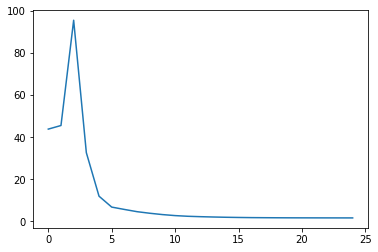

Epoch 1/25
1/1 - 3s - loss: 35.8511 - accuracy: 0.2321 - auc_6: 0.5233 - val_loss: 175.4931 - val_accuracy: 0.5378 - val_auc_6: 0.7111 - 3s/epoch - 3s/step
Epoch 2/25
1/1 - 0s - loss: 171.9389 - accuracy: 0.5654 - auc_6: 0.7284 - val_loss: 102.3149 - val_accuracy: 0.2521 - val_auc_6: 0.5317 - 498ms/epoch - 498ms/step
Epoch 3/25
1/1 - 1s - loss: 105.8047 - accuracy: 0.1941 - auc_6: 0.4975 - val_loss: 73.3839 - val_accuracy: 0.2017 - val_auc_6: 0.5011 - 525ms/epoch - 525ms/step
Epoch 4/25
1/1 - 1s - loss: 73.6841 - accuracy: 0.1730 - auc_6: 0.4819 - val_loss: 40.9584 - val_accuracy: 0.4370 - val_auc_6: 0.6727 - 525ms/epoch - 525ms/step
Epoch 5/25
1/1 - 1s - loss: 41.2351 - accuracy: 0.4852 - auc_6: 0.6898 - val_loss: 33.3492 - val_accuracy: 0.5294 - val_auc_6: 0.7092 - 524ms/epoch - 524ms/step
Epoch 6/25
1/1 - 1s - loss: 31.5853 - accuracy: 0.5570 - auc_6: 0.7240 - val_loss: 25.0968 - val_accuracy: 0.5294 - val_auc_6: 0.7135 - 508ms/epoch - 508ms/step
Epoch 7/25
1/1 - 0s - loss: 23.5196 

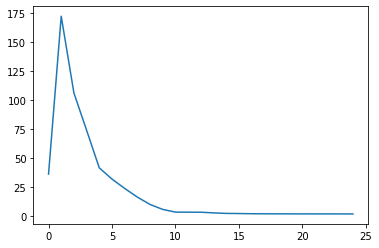

Epoch 1/25
1/1 - 3s - loss: 73.7087 - accuracy: 0.1807 - auc_7: 0.4872 - val_loss: 385.7934 - val_accuracy: 0.5339 - val_auc_7: 0.7087 - 3s/epoch - 3s/step
Epoch 2/25
1/1 - 1s - loss: 325.2373 - accuracy: 0.5672 - auc_7: 0.7295 - val_loss: 281.0327 - val_accuracy: 0.1695 - val_auc_7: 0.4809 - 559ms/epoch - 559ms/step
Epoch 3/25
1/1 - 1s - loss: 224.8951 - accuracy: 0.1891 - auc_7: 0.4932 - val_loss: 209.8470 - val_accuracy: 0.5339 - val_auc_7: 0.7087 - 558ms/epoch - 558ms/step
Epoch 4/25
1/1 - 1s - loss: 170.0856 - accuracy: 0.5672 - auc_7: 0.7295 - val_loss: 149.5153 - val_accuracy: 0.5339 - val_auc_7: 0.7087 - 692ms/epoch - 692ms/step
Epoch 5/25
1/1 - 1s - loss: 119.5103 - accuracy: 0.5672 - auc_7: 0.7295 - val_loss: 91.3976 - val_accuracy: 0.5339 - val_auc_7: 0.7088 - 705ms/epoch - 705ms/step
Epoch 6/25
1/1 - 1s - loss: 71.9680 - accuracy: 0.5672 - auc_7: 0.7282 - val_loss: 49.1070 - val_accuracy: 0.5339 - val_auc_7: 0.7149 - 723ms/epoch - 723ms/step
Epoch 7/25
1/1 - 1s - loss: 38.8

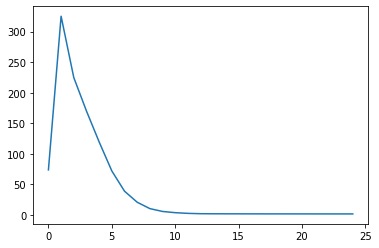

In [12]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = get_convLSTM_model(n_features, n_length, n_outputs)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [13]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 29.630%

AUC: 0.503


### 1.3 Pain level detection - CNN+LSTM

#### Dataset

In [14]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_level', 'skeleton')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 38) (534, 3)
(81, 1, 350, 38) (81, 3)


#### Model

In [15]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [16]:
model = get_CNN_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, None, 348, 64)    7360      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, None, 348, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, None, 11136)      0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 100)               4494800   
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                      

#### KFold CV

Epoch 1/25
2/2 - 3s - loss: 1.0045 - accuracy: 0.5646 - auc_9: 0.6866 - val_loss: 0.8759 - val_accuracy: 0.6629 - val_auc_9: 0.8066 - 3s/epoch - 2s/step
Epoch 2/25
2/2 - 0s - loss: 0.8954 - accuracy: 0.6320 - auc_9: 0.8221 - val_loss: 0.8325 - val_accuracy: 0.6629 - val_auc_9: 0.8142 - 244ms/epoch - 122ms/step
Epoch 3/25
2/2 - 0s - loss: 0.8564 - accuracy: 0.6320 - auc_9: 0.7983 - val_loss: 0.7933 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 247ms/epoch - 124ms/step
Epoch 4/25
2/2 - 0s - loss: 0.8102 - accuracy: 0.6320 - auc_9: 0.8084 - val_loss: 0.7703 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 243ms/epoch - 122ms/step
Epoch 5/25
2/2 - 0s - loss: 0.7781 - accuracy: 0.6320 - auc_9: 0.8169 - val_loss: 0.7580 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 279ms/epoch - 139ms/step
Epoch 6/25
2/2 - 0s - loss: 0.7589 - accuracy: 0.6320 - auc_9: 0.8183 - val_loss: 0.7534 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 335ms/epoch - 168ms/step
Epoch 7/25
2/2 - 0s - loss: 0.7480 - accuracy: 0.632

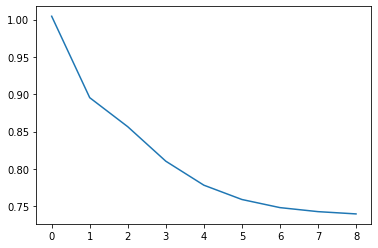

Epoch 1/25
2/2 - 2s - loss: 0.9686 - accuracy: 0.6489 - auc_10: 0.7014 - val_loss: 0.8447 - val_accuracy: 0.6292 - val_auc_10: 0.8160 - 2s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 0.8344 - accuracy: 0.6489 - auc_10: 0.8024 - val_loss: 0.8277 - val_accuracy: 0.6292 - val_auc_10: 0.8109 - 256ms/epoch - 128ms/step
Epoch 3/25
2/2 - 0s - loss: 0.8157 - accuracy: 0.6489 - auc_10: 0.8110 - val_loss: 0.7993 - val_accuracy: 0.6292 - val_auc_10: 0.8081 - 259ms/epoch - 130ms/step
Epoch 4/25
2/2 - 0s - loss: 0.7955 - accuracy: 0.6489 - auc_10: 0.8137 - val_loss: 0.7797 - val_accuracy: 0.6292 - val_auc_10: 0.8118 - 248ms/epoch - 124ms/step
Epoch 5/25
2/2 - 0s - loss: 0.7824 - accuracy: 0.6489 - auc_10: 0.8113 - val_loss: 0.7638 - val_accuracy: 0.6292 - val_auc_10: 0.8116 - 247ms/epoch - 123ms/step
Epoch 6/25
2/2 - 0s - loss: 0.7711 - accuracy: 0.6489 - auc_10: 0.8144 - val_loss: 0.7497 - val_accuracy: 0.6292 - val_auc_10: 0.8118 - 256ms/epoch - 128ms/step
Epoch 7/25
2/2 - 0s - loss: 0.7639 - acc

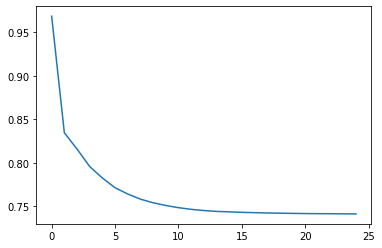

Epoch 1/25
2/2 - 3s - loss: 1.0505 - accuracy: 0.4354 - auc_11: 0.6368 - val_loss: 0.9420 - val_accuracy: 0.3427 - val_auc_11: 0.6560 - 3s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 0.9295 - accuracy: 0.3371 - auc_11: 0.6536 - val_loss: 0.8743 - val_accuracy: 0.3315 - val_auc_11: 0.6520 - 254ms/epoch - 127ms/step
Epoch 3/25
2/2 - 0s - loss: 0.8591 - accuracy: 0.4410 - auc_11: 0.7441 - val_loss: 0.8263 - val_accuracy: 0.6348 - val_auc_11: 0.8020 - 250ms/epoch - 125ms/step
Epoch 4/25
2/2 - 0s - loss: 0.8124 - accuracy: 0.6461 - auc_11: 0.8148 - val_loss: 0.7971 - val_accuracy: 0.6348 - val_auc_11: 0.8055 - 259ms/epoch - 129ms/step
Epoch 5/25
2/2 - 0s - loss: 0.7847 - accuracy: 0.6461 - auc_11: 0.8025 - val_loss: 0.7819 - val_accuracy: 0.6348 - val_auc_11: 0.8052 - 258ms/epoch - 129ms/step
Epoch 6/25
2/2 - 0s - loss: 0.7673 - accuracy: 0.6461 - auc_11: 0.8081 - val_loss: 0.7739 - val_accuracy: 0.6348 - val_auc_11: 0.8052 - 263ms/epoch - 132ms/step
Epoch 7/25
2/2 - 0s - loss: 0.7575 - acc

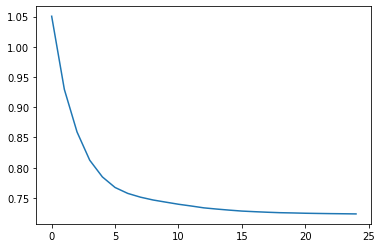

In [17]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = get_CNN_model(n_features, n_length, n_outputs)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [18]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 77.778%

AUC: 0.8704


### 1.4 Pain level detection - Convolutional LSTM

#### Model

In [19]:
model = get_convLSTM_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_4 (ConvLSTM1D)  (None, 348, 64)           78592     
                                                                 
 flatten_12 (Flatten)        (None, 22272)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               2227300   
                                                                 
 dense_25 (Dense)            (None, 3)                 303       
                                                                 
Total params: 2,306,195
Trainable params: 2,306,195
Non-trainable params: 0
_________________________________________________________________


#### KFold CV

Epoch 1/25
1/1 - 4s - loss: 38.9102 - accuracy: 0.6582 - auc_13: 0.7437 - val_loss: 418.7241 - val_accuracy: 0.3529 - val_auc_13: 0.5147 - 4s/epoch - 4s/step
Epoch 2/25
1/1 - 1s - loss: 447.3606 - accuracy: 0.3291 - auc_13: 0.4968 - val_loss: 168.6344 - val_accuracy: 0.1176 - val_auc_13: 0.3102 - 583ms/epoch - 583ms/step
Epoch 3/25
1/1 - 1s - loss: 183.6308 - accuracy: 0.1477 - auc_13: 0.3468 - val_loss: 18.0738 - val_accuracy: 0.3866 - val_auc_13: 0.5320 - 554ms/epoch - 554ms/step
Epoch 4/25
1/1 - 1s - loss: 14.8934 - accuracy: 0.3418 - auc_13: 0.5359 - val_loss: 17.7999 - val_accuracy: 0.6218 - val_auc_13: 0.7164 - 557ms/epoch - 557ms/step
Epoch 5/25
1/1 - 1s - loss: 15.7549 - accuracy: 0.6582 - auc_13: 0.7437 - val_loss: 13.7919 - val_accuracy: 0.6218 - val_auc_13: 0.7164 - 550ms/epoch - 550ms/step
Epoch 6/25
1/1 - 1s - loss: 11.6265 - accuracy: 0.6582 - auc_13: 0.7437 - val_loss: 6.6214 - val_accuracy: 0.6218 - val_auc_13: 0.7179 - 573ms/epoch - 573ms/step
Epoch 7/25
1/1 - 1s - los

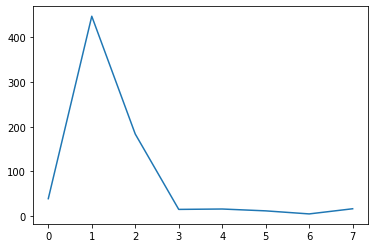

Epoch 1/25
1/1 - 3s - loss: 26.4883 - accuracy: 0.3291 - auc_14: 0.5081 - val_loss: 16.1996 - val_accuracy: 0.4706 - val_auc_14: 0.6250 - 3s/epoch - 3s/step
Epoch 2/25
1/1 - 1s - loss: 30.8342 - accuracy: 0.5105 - auc_14: 0.6394 - val_loss: 123.1418 - val_accuracy: 0.6218 - val_auc_14: 0.7164 - 693ms/epoch - 693ms/step
Epoch 3/25
1/1 - 1s - loss: 128.1936 - accuracy: 0.6582 - auc_14: 0.7437 - val_loss: 7.1166 - val_accuracy: 0.5378 - val_auc_14: 0.6915 - 557ms/epoch - 557ms/step
Epoch 4/25
1/1 - 1s - loss: 23.6853 - accuracy: 0.5696 - auc_14: 0.7135 - val_loss: 98.7649 - val_accuracy: 0.3782 - val_auc_14: 0.5336 - 545ms/epoch - 545ms/step
Epoch 5/25
1/1 - 1s - loss: 120.5050 - accuracy: 0.3165 - auc_14: 0.4873 - val_loss: 19.2039 - val_accuracy: 0.3697 - val_auc_14: 0.5346 - 563ms/epoch - 563ms/step


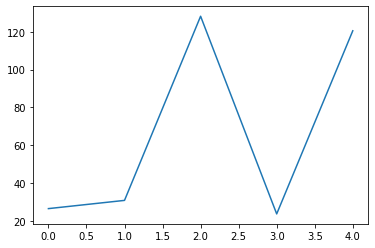

Epoch 1/25
1/1 - 4s - loss: 75.9524 - accuracy: 0.0378 - auc_15: 0.2777 - val_loss: 342.3707 - val_accuracy: 0.2797 - val_auc_15: 0.4597 - 4s/epoch - 4s/step
Epoch 2/25
1/1 - 1s - loss: 270.7342 - accuracy: 0.3655 - auc_15: 0.5242 - val_loss: 137.5090 - val_accuracy: 0.6949 - val_auc_15: 0.7712 - 558ms/epoch - 558ms/step
Epoch 3/25
1/1 - 1s - loss: 142.1431 - accuracy: 0.6218 - auc_15: 0.7164 - val_loss: 136.3108 - val_accuracy: 0.6949 - val_auc_15: 0.7712 - 583ms/epoch - 583ms/step
Epoch 4/25
1/1 - 1s - loss: 138.6781 - accuracy: 0.6218 - auc_15: 0.7164 - val_loss: 90.5149 - val_accuracy: 0.6949 - val_auc_15: 0.7712 - 543ms/epoch - 543ms/step
Epoch 5/25
1/1 - 1s - loss: 83.9545 - accuracy: 0.6218 - auc_15: 0.7164 - val_loss: 44.0144 - val_accuracy: 0.4068 - val_auc_15: 0.5859 - 545ms/epoch - 545ms/step
Epoch 6/25
1/1 - 1s - loss: 25.3462 - accuracy: 0.4706 - auc_15: 0.6330 - val_loss: 74.2498 - val_accuracy: 0.2797 - val_auc_15: 0.4600 - 572ms/epoch - 572ms/step
Epoch 7/25
1/1 - 1s - 

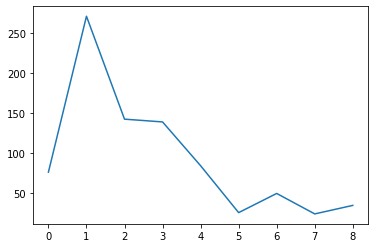

In [20]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = get_convLSTM_model(n_features, n_length, n_outputs)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [21]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 77.778%

AUC: 0.8333


## 2. Face Modality (Action Units)

### 2.1 Pain area prediction - CNN+LSTM

#### Dataset

In [22]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_area', 'AUs')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(208, 1, 350, 10) (208, 5)
(27, 1, 350, 10) (27, 5)


#### Model

In [23]:
batch_size = 68
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [24]:
model = get_CNN_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, None, 348, 64)    1984      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, None, 348, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, None, 11136)      0         
 stributed)                                                      
                                                                 
 lstm_8 (LSTM)               (None, 100)               4494800   
                                                                 
 dense_32 (Dense)            (None, 100)               10100     
                                                     

#### KFold CV

Epoch 1/25
3/3 - 4s - loss: 1.4906 - accuracy: 0.3261 - auc_17: 0.6483 - val_loss: 1.2994 - val_accuracy: 0.5000 - val_auc_17: 0.7633 - 4s/epoch - 1s/step
Epoch 2/25
3/3 - 0s - loss: 1.2702 - accuracy: 0.5217 - auc_17: 0.7926 - val_loss: 1.3391 - val_accuracy: 0.5000 - val_auc_17: 0.7530 - 157ms/epoch - 52ms/step
Epoch 3/25
3/3 - 0s - loss: 1.2980 - accuracy: 0.5290 - auc_17: 0.8069 - val_loss: 1.2860 - val_accuracy: 0.5000 - val_auc_17: 0.7928 - 165ms/epoch - 55ms/step
Epoch 4/25
3/3 - 0s - loss: 1.2447 - accuracy: 0.5217 - auc_17: 0.8145 - val_loss: 1.2445 - val_accuracy: 0.5000 - val_auc_17: 0.8069 - 160ms/epoch - 53ms/step
Epoch 5/25
3/3 - 0s - loss: 1.2249 - accuracy: 0.5217 - auc_17: 0.8079 - val_loss: 1.2229 - val_accuracy: 0.5000 - val_auc_17: 0.8141 - 214ms/epoch - 71ms/step
Epoch 6/25
3/3 - 0s - loss: 1.2169 - accuracy: 0.5217 - auc_17: 0.8096 - val_loss: 1.2294 - val_accuracy: 0.5000 - val_auc_17: 0.8172 - 202ms/epoch - 67ms/step
Epoch 7/25
3/3 - 0s - loss: 1.2079 - accuracy

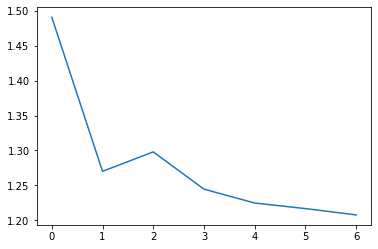

Epoch 1/25
3/3 - 3s - loss: 1.4103 - accuracy: 0.3813 - auc_18: 0.7204 - val_loss: 1.5045 - val_accuracy: 0.4928 - val_auc_18: 0.7878 - 3s/epoch - 999ms/step
Epoch 2/25
3/3 - 0s - loss: 1.4273 - accuracy: 0.5252 - auc_18: 0.8021 - val_loss: 1.4331 - val_accuracy: 0.4928 - val_auc_18: 0.7881 - 161ms/epoch - 54ms/step
Epoch 3/25
3/3 - 0s - loss: 1.3011 - accuracy: 0.5252 - auc_18: 0.8168 - val_loss: 1.2975 - val_accuracy: 0.4928 - val_auc_18: 0.7916 - 160ms/epoch - 53ms/step
Epoch 4/25
3/3 - 0s - loss: 1.1901 - accuracy: 0.5252 - auc_18: 0.8194 - val_loss: 1.2460 - val_accuracy: 0.4928 - val_auc_18: 0.7919 - 158ms/epoch - 53ms/step
Epoch 5/25
3/3 - 0s - loss: 1.1504 - accuracy: 0.5252 - auc_18: 0.8301 - val_loss: 1.2443 - val_accuracy: 0.5072 - val_auc_18: 0.7883 - 158ms/epoch - 53ms/step
Epoch 6/25
3/3 - 0s - loss: 1.1281 - accuracy: 0.5468 - auc_18: 0.8430 - val_loss: 1.2564 - val_accuracy: 0.4928 - val_auc_18: 0.7788 - 171ms/epoch - 57ms/step
Epoch 7/25
3/3 - 0s - loss: 1.1315 - accur

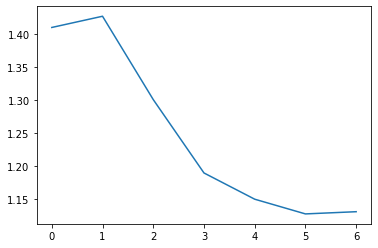

Epoch 1/25
3/3 - 3s - loss: 1.5417 - accuracy: 0.2806 - auc_19: 0.5995 - val_loss: 1.2836 - val_accuracy: 0.5507 - val_auc_19: 0.7797 - 3s/epoch - 927ms/step
Epoch 2/25
3/3 - 0s - loss: 1.2822 - accuracy: 0.4964 - auc_19: 0.7898 - val_loss: 1.3107 - val_accuracy: 0.5507 - val_auc_19: 0.7767 - 218ms/epoch - 73ms/step
Epoch 3/25
3/3 - 0s - loss: 1.2862 - accuracy: 0.4964 - auc_19: 0.7909 - val_loss: 1.3548 - val_accuracy: 0.5362 - val_auc_19: 0.7602 - 200ms/epoch - 67ms/step


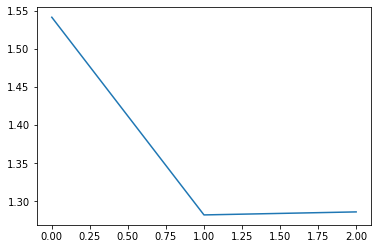

In [25]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = get_CNN_model(n_features, n_length, n_outputs)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [26]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 59.259%

AUC: 0.7761


### 2.2 Pain area prediction - Convolutional LSTM

#### Model

In [27]:
model = get_convLSTM_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_8 (ConvLSTM1D)  (None, 348, 64)           57088     
                                                                 
 flatten_20 (Flatten)        (None, 22272)             0         
                                                                 
 dense_40 (Dense)            (None, 100)               2227300   
                                                                 
 dense_41 (Dense)            (None, 5)                 505       
                                                                 
Total params: 2,284,893
Trainable params: 2,284,893
Non-trainable params: 0
_________________________________________________________________


#### KFold CV

Epoch 1/25
2/2 - 4s - loss: 1.5378 - accuracy: 0.1848 - auc_21: 0.5718 - val_loss: 1.4510 - val_accuracy: 0.5106 - val_auc_21: 0.7587 - 4s/epoch - 2s/step
Epoch 2/25
2/2 - 0s - loss: 1.3416 - accuracy: 0.4891 - auc_21: 0.7772 - val_loss: 1.6837 - val_accuracy: 0.2766 - val_auc_21: 0.6596 - 230ms/epoch - 115ms/step
Epoch 3/25
2/2 - 0s - loss: 1.2273 - accuracy: 0.4022 - auc_21: 0.7969 - val_loss: 1.5431 - val_accuracy: 0.3617 - val_auc_21: 0.6978 - 238ms/epoch - 119ms/step


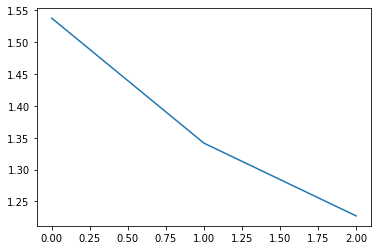

Epoch 1/25
2/2 - 3s - loss: 1.5232 - accuracy: 0.3441 - auc_22: 0.5727 - val_loss: 1.4150 - val_accuracy: 0.4348 - val_auc_22: 0.7384 - 3s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 1.2352 - accuracy: 0.5269 - auc_22: 0.7939 - val_loss: 1.2791 - val_accuracy: 0.4348 - val_auc_22: 0.7818 - 279ms/epoch - 139ms/step
Epoch 3/25
2/2 - 0s - loss: 1.1557 - accuracy: 0.4946 - auc_22: 0.8199 - val_loss: 1.2641 - val_accuracy: 0.4565 - val_auc_22: 0.7875 - 232ms/epoch - 116ms/step
Epoch 4/25
2/2 - 0s - loss: 1.1021 - accuracy: 0.5376 - auc_22: 0.8419 - val_loss: 1.3004 - val_accuracy: 0.4348 - val_auc_22: 0.7804 - 238ms/epoch - 119ms/step
Epoch 5/25
2/2 - 0s - loss: 1.0254 - accuracy: 0.5376 - auc_22: 0.8750 - val_loss: 1.3591 - val_accuracy: 0.4348 - val_auc_22: 0.7640 - 232ms/epoch - 116ms/step


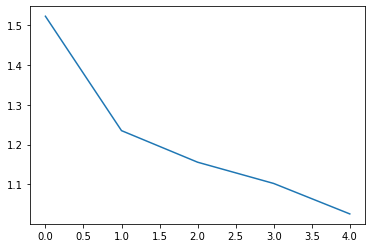

Epoch 1/25
2/2 - 5s - loss: 1.5338 - accuracy: 0.2796 - auc_23: 0.6036 - val_loss: 1.3370 - val_accuracy: 0.5435 - val_auc_23: 0.7343 - 5s/epoch - 2s/step
Epoch 2/25
2/2 - 0s - loss: 1.2386 - accuracy: 0.4839 - auc_23: 0.8178 - val_loss: 1.2115 - val_accuracy: 0.5652 - val_auc_23: 0.8087 - 298ms/epoch - 149ms/step
Epoch 3/25
2/2 - 0s - loss: 1.0992 - accuracy: 0.5376 - auc_23: 0.8679 - val_loss: 1.2313 - val_accuracy: 0.5435 - val_auc_23: 0.8049 - 254ms/epoch - 127ms/step
Epoch 4/25
2/2 - 0s - loss: 1.0226 - accuracy: 0.6022 - auc_23: 0.8773 - val_loss: 1.2675 - val_accuracy: 0.5217 - val_auc_23: 0.8038 - 251ms/epoch - 125ms/step


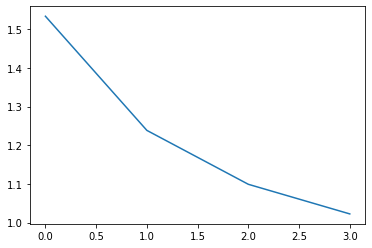

In [28]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = get_convLSTM_model(n_features, n_length, n_outputs)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [29]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 59.259%

AUC: 0.8057


### 2.3 Pain level prediction - CNN+LSTM

#### Dataset

In [30]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_level', 'AUs')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(208, 1, 350, 10) (208, 3)
(27, 1, 350, 10) (27, 3)


#### Model

In [31]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [32]:
model = get_CNN_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, None, 348, 64)    1984      
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, None, 348, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, None, 11136)      0         
 stributed)                                                      
                                                                 
 lstm_12 (LSTM)              (None, 100)               4494800   
                                                                 
 dense_48 (Dense)            (None, 100)               10100     
                                                     

#### KFold CV

Epoch 1/25
3/3 - 4s - loss: 0.8806 - accuracy: 0.5435 - auc_25: 0.7354 - val_loss: 0.9888 - val_accuracy: 0.5714 - val_auc_25: 0.8052 - 4s/epoch - 1s/step
Epoch 2/25
3/3 - 0s - loss: 0.7329 - accuracy: 0.6884 - auc_25: 0.8850 - val_loss: 0.8248 - val_accuracy: 0.5714 - val_auc_25: 0.8083 - 224ms/epoch - 75ms/step
Epoch 3/25
3/3 - 0s - loss: 0.6138 - accuracy: 0.6884 - auc_25: 0.8813 - val_loss: 0.7244 - val_accuracy: 0.5857 - val_auc_25: 0.8102 - 183ms/epoch - 61ms/step
Epoch 4/25
3/3 - 0s - loss: 0.6167 - accuracy: 0.7464 - auc_25: 0.9018 - val_loss: 0.7321 - val_accuracy: 0.6000 - val_auc_25: 0.8147 - 191ms/epoch - 64ms/step
Epoch 5/25
3/3 - 0s - loss: 0.5927 - accuracy: 0.7029 - auc_25: 0.8965 - val_loss: 0.7625 - val_accuracy: 0.5571 - val_auc_25: 0.8119 - 170ms/epoch - 57ms/step


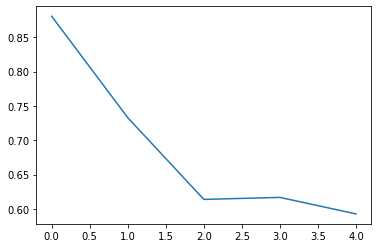

Epoch 1/25
3/3 - 3s - loss: 0.9228 - accuracy: 0.6475 - auc_26: 0.7530 - val_loss: 0.7332 - val_accuracy: 0.6522 - val_auc_26: 0.8510 - 3s/epoch - 1s/step
Epoch 2/25
3/3 - 0s - loss: 0.7047 - accuracy: 0.6475 - auc_26: 0.8594 - val_loss: 0.6958 - val_accuracy: 0.6522 - val_auc_26: 0.8545 - 162ms/epoch - 54ms/step
Epoch 3/25
3/3 - 0s - loss: 0.6485 - accuracy: 0.6547 - auc_26: 0.8648 - val_loss: 0.6639 - val_accuracy: 0.6812 - val_auc_26: 0.8651 - 180ms/epoch - 60ms/step
Epoch 4/25
3/3 - 0s - loss: 0.6120 - accuracy: 0.7122 - auc_26: 0.8870 - val_loss: 0.6576 - val_accuracy: 0.6957 - val_auc_26: 0.8634 - 163ms/epoch - 54ms/step
Epoch 5/25
3/3 - 0s - loss: 0.5975 - accuracy: 0.6906 - auc_26: 0.8923 - val_loss: 0.6609 - val_accuracy: 0.6957 - val_auc_26: 0.8625 - 164ms/epoch - 55ms/step
Epoch 6/25
3/3 - 0s - loss: 0.5852 - accuracy: 0.7194 - auc_26: 0.8977 - val_loss: 0.6634 - val_accuracy: 0.6957 - val_auc_26: 0.8657 - 153ms/epoch - 51ms/step


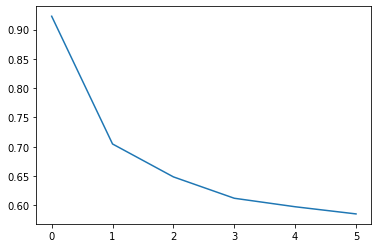

Epoch 1/25
3/3 - 3s - loss: 0.9305 - accuracy: 0.3885 - auc_27: 0.6809 - val_loss: 0.5997 - val_accuracy: 0.7246 - val_auc_27: 0.9066 - 3s/epoch - 1s/step
Epoch 2/25
3/3 - 0s - loss: 0.7450 - accuracy: 0.6115 - auc_27: 0.8305 - val_loss: 0.6616 - val_accuracy: 0.6957 - val_auc_27: 0.8788 - 163ms/epoch - 54ms/step
Epoch 3/25
3/3 - 0s - loss: 0.6926 - accuracy: 0.6691 - auc_27: 0.8731 - val_loss: 0.5736 - val_accuracy: 0.7391 - val_auc_27: 0.9069 - 166ms/epoch - 55ms/step
Epoch 4/25
3/3 - 0s - loss: 0.6667 - accuracy: 0.6619 - auc_27: 0.8605 - val_loss: 0.5871 - val_accuracy: 0.7101 - val_auc_27: 0.8917 - 169ms/epoch - 56ms/step
Epoch 5/25
3/3 - 0s - loss: 0.6559 - accuracy: 0.6547 - auc_27: 0.8688 - val_loss: 0.6542 - val_accuracy: 0.6377 - val_auc_27: 0.8484 - 155ms/epoch - 52ms/step


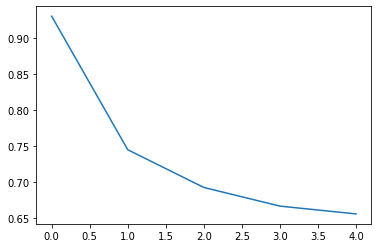

In [33]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = get_CNN_model(n_features, n_length, n_outputs)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [34]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 29.630%

AUC: 0.7099


### 2.4 Pain level prediction - Convolutional LSTM

#### Model

In [35]:
model = get_convLSTM_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d_12 (ConvLSTM1D)  (None, 348, 64)          57088     
                                                                 
 flatten_28 (Flatten)        (None, 22272)             0         
                                                                 
 dense_56 (Dense)            (None, 100)               2227300   
                                                                 
 dense_57 (Dense)            (None, 3)                 303       
                                                                 
Total params: 2,284,691
Trainable params: 2,284,691
Non-trainable params: 0
_________________________________________________________________


#### KFold CV

Epoch 1/25
2/2 - 4s - loss: 0.9932 - accuracy: 0.5761 - auc_29: 0.7421 - val_loss: 0.8667 - val_accuracy: 0.5957 - val_auc_29: 0.7976 - 4s/epoch - 2s/step
Epoch 2/25
2/2 - 0s - loss: 0.6893 - accuracy: 0.6087 - auc_29: 0.8276 - val_loss: 0.8798 - val_accuracy: 0.6170 - val_auc_29: 0.7918 - 260ms/epoch - 130ms/step
Epoch 3/25
2/2 - 0s - loss: 0.5889 - accuracy: 0.6196 - auc_29: 0.8782 - val_loss: 0.9912 - val_accuracy: 0.6170 - val_auc_29: 0.7909 - 265ms/epoch - 132ms/step


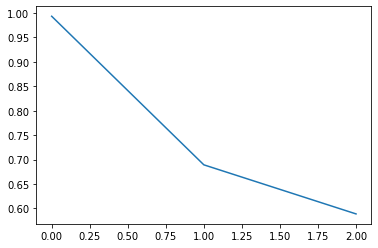

Epoch 1/25
2/2 - 4s - loss: 1.0201 - accuracy: 0.5269 - auc_30: 0.6942 - val_loss: 0.9661 - val_accuracy: 0.5435 - val_auc_30: 0.7870 - 4s/epoch - 2s/step
Epoch 2/25
2/2 - 0s - loss: 0.7968 - accuracy: 0.6452 - auc_30: 0.8415 - val_loss: 0.7326 - val_accuracy: 0.6304 - val_auc_30: 0.8360 - 256ms/epoch - 128ms/step
Epoch 3/25
2/2 - 0s - loss: 0.7007 - accuracy: 0.7097 - auc_30: 0.8822 - val_loss: 0.7261 - val_accuracy: 0.5435 - val_auc_30: 0.8110 - 250ms/epoch - 125ms/step
Epoch 4/25
2/2 - 0s - loss: 0.6749 - accuracy: 0.6882 - auc_30: 0.8824 - val_loss: 0.6990 - val_accuracy: 0.5652 - val_auc_30: 0.8129 - 250ms/epoch - 125ms/step
Epoch 5/25
2/2 - 0s - loss: 0.6064 - accuracy: 0.7312 - auc_30: 0.8939 - val_loss: 0.7479 - val_accuracy: 0.5435 - val_auc_30: 0.8078 - 260ms/epoch - 130ms/step
Epoch 6/25
2/2 - 0s - loss: 0.6024 - accuracy: 0.6989 - auc_30: 0.8895 - val_loss: 0.7426 - val_accuracy: 0.5435 - val_auc_30: 0.8033 - 249ms/epoch - 125ms/step


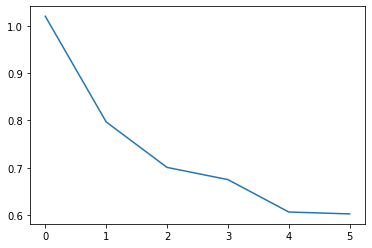

Epoch 1/25
2/2 - 3s - loss: 1.0725 - accuracy: 0.3978 - auc_31: 0.5956 - val_loss: 0.6904 - val_accuracy: 0.6522 - val_auc_31: 0.8704 - 3s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 0.7570 - accuracy: 0.5806 - auc_31: 0.8128 - val_loss: 0.6663 - val_accuracy: 0.6522 - val_auc_31: 0.8526 - 250ms/epoch - 125ms/step
Epoch 3/25
2/2 - 0s - loss: 0.6637 - accuracy: 0.6882 - auc_31: 0.8746 - val_loss: 0.6163 - val_accuracy: 0.6087 - val_auc_31: 0.8702 - 258ms/epoch - 129ms/step
Epoch 4/25
2/2 - 0s - loss: 0.6930 - accuracy: 0.6559 - auc_31: 0.8534 - val_loss: 0.6180 - val_accuracy: 0.6739 - val_auc_31: 0.8670 - 243ms/epoch - 122ms/step
Epoch 5/25
2/2 - 0s - loss: 0.6483 - accuracy: 0.7097 - auc_31: 0.8725 - val_loss: 0.6747 - val_accuracy: 0.6087 - val_auc_31: 0.8218 - 245ms/epoch - 123ms/step


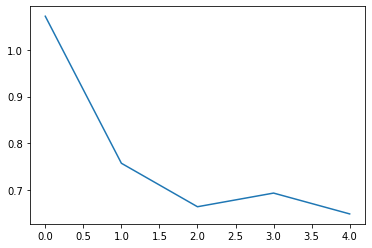

In [36]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = get_convLSTM_model(n_features, n_length, n_outputs)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [37]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 37.037%

AUC: 0.7692


## 3. Results

In [38]:
def show_results(first, last):
    plt.rcParams['figure.figsize'] = (8,8)
    x = np.arange(len(model_names[first:last]))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, accuracies[first:last], width, label='Accuracy')
    rects2 = ax.bar(x + width/2, aucs[first:last], width, label='AUC * 100')

    ax.set_ylim(0, 100)
    ax.set_xticks(x, model_names[first:last])
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

### Body Modality (Skeleton) - Pain area prediction 

CNN+LSTM vs Convolutional LSTM

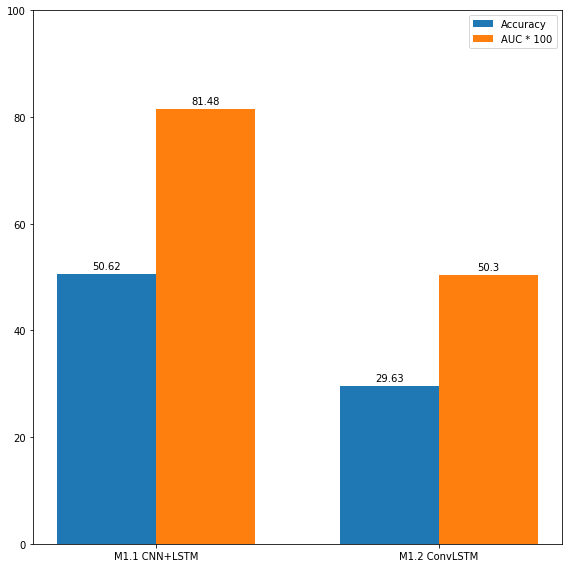

In [39]:
show_results(0, 2)

### Body Modality (Skeleton) - Pain level prediction 

CNN+LSTM vs Convolutional LSTM

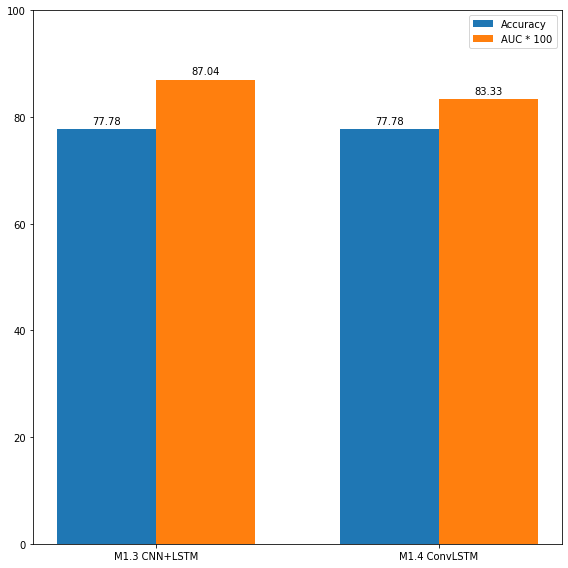

In [40]:
show_results(2, 4)

### Face Modality (Action Units) - Pain area prediction 

CNN+LSTM vs Convolutional LSTM

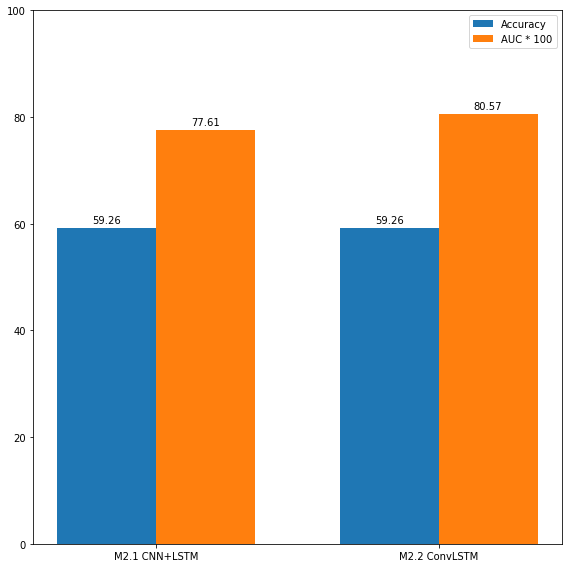

In [41]:
show_results(4, 6)

### Face Modality (Action Units) - Pain level prediction 

CNN+LSTM vs Convolutional LSTM

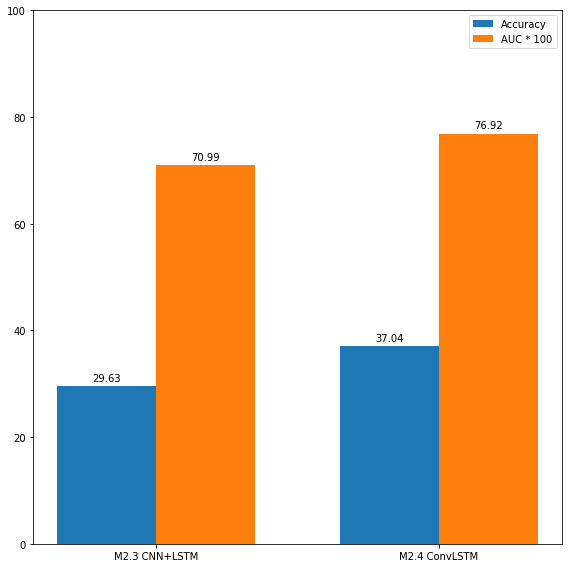

In [42]:
show_results(6, 8)